In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

In [ ]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

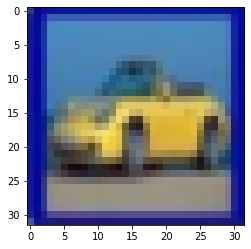

In [ ]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i], cmap='gray');

In [ ]:
trainloader.dataset.data[i].shape

(32, 32, 3)

In [ ]:
next(iter(trainloader))[0].shape


torch.Size([128, 3, 32, 32])

In [ ]:
from torch.utils.data import random_split
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        accu = accuracy(out,labels)
        return loss,accu
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'Loss': loss.detach(), 'Accuracy': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{result["train_accuracy"]*100:.2f}% Validation Accuracy:{result["Accuracy"]*100:.2f}%')
        print(f'Train Loss:{result["train_loss"]:.4f} Validation Loss:{result["Loss"]:.4f}')

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)


In [ ]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader,epochs=10,learning_rate=0.001):
    best_valid = None
    history = []
    optimizer = torch.optim.Adam(model.parameters(), learning_rate,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in tqdm(train_loader):
            loss,accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        if(best_valid == None or best_valid<result['Accuracy']):
            best_valid=result['Accuracy']
            torch.save(model.state_dict(), 'cifar10-cnn.pth')
        history.append(result)
    return history


In [ ]:
imgClass =  ImageClassificationBase()

In [ ]:
model = Cifar10CnnModel()

In [ ]:
from tqdm import tqdm

In [ ]:
history = fit(model, train_dl, val_dl)

  0%|          | 0/704 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 704/704 [13:35<00:00,  1.16s/it]


Epoch : 1
Train Accuracy:57.52% Validation Accuracy:67.46%
Train Loss:1.1797 Validation Loss:0.9138


100%|██████████| 704/704 [13:14<00:00,  1.13s/it]


Epoch : 2
Train Accuracy:73.56% Validation Accuracy:71.28%
Train Loss:0.7595 Validation Loss:0.8491


100%|██████████| 704/704 [13:16<00:00,  1.13s/it]


Epoch : 3
Train Accuracy:78.97% Validation Accuracy:78.07%
Train Loss:0.6082 Validation Loss:0.6352


100%|██████████| 704/704 [13:19<00:00,  1.14s/it]


Epoch : 4
Train Accuracy:82.35% Validation Accuracy:79.23%
Train Loss:0.5111 Validation Loss:0.6183


100%|██████████| 704/704 [13:18<00:00,  1.13s/it]


Epoch : 5
Train Accuracy:84.69% Validation Accuracy:79.91%
Train Loss:0.4453 Validation Loss:0.6053


  7%|▋         | 52/704 [01:00<12:38,  1.16s/it]


KeyboardInterrupt: ignored

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = model(images)#.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 82 %
Accuracy of  bird : 81 %
Accuracy of   cat : 64 %
Accuracy of  deer : 66 %
Accuracy of   dog : 78 %
Accuracy of  frog : 83 %
Accuracy of horse : 80 %
Accuracy of  ship : 96 %
Accuracy of truck : 82 %


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %
